<a href="https://colab.research.google.com/github/mkhfring/cosc419-notes/blob/main/gradient_decent_second_part.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward

    return out


  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()



In [5]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

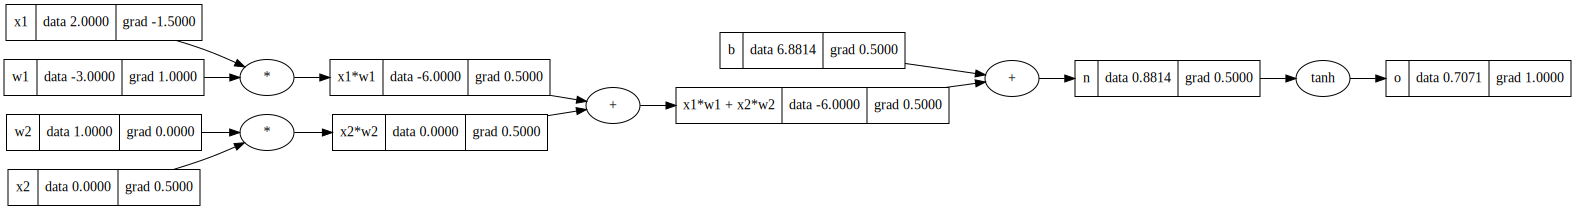

In [ ]:
draw_dot(o)

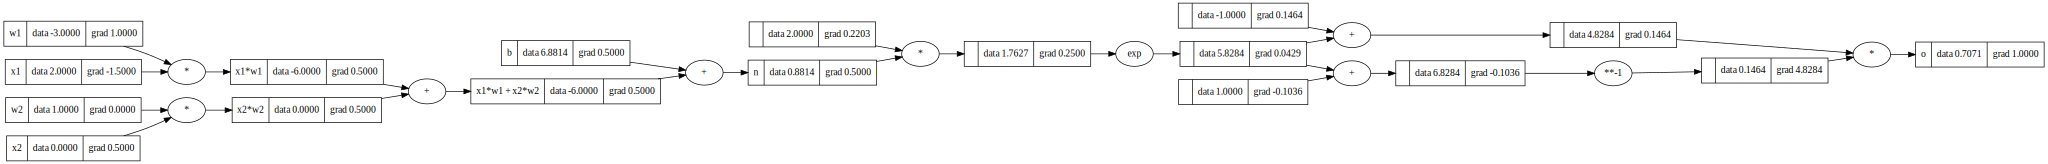

In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

In [ ]:
import torch

In [ ]:

x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [ ]:
a = torch.tensor([[1,2,3], [4,5,6]])
a.shape

torch.Size([2, 3])

In [ ]:
a =[1, 3, 4]
b = [6, 7, 9]
for i, j in zip(a, b):
  print(i, j)

1 6
3 7
4 9


In [ ]:
class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return 0.0




In [ ]:
x = [2.0, 3.0]
n = Neuron(2)
n(x)

0.0

In [ ]:
class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
    # self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]

    # outs = [n(x) for n in self.neurons]
    return outs



In [ ]:
x = [2.0, 3.0]
n = Layer(2, 3)
n(x)

[Value(data=-0.8711620415142001),
 Value(data=-0.9834577198316257),
 Value(data=-0.6901409462682421)]

Value(data=-0.7909542914613296)

In [6]:

class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]




In [7]:
x = [2.0, 3.0]
n = MLP(2, [4,4,1])
n(x)

Value(data=-0.6469441562567483)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random


class PyNeuron:

  def __init__(self, nin):
    self.w = torch.randn(nin, requires_grad=True)  # Randomly initialize weights
    self.b = torch.randn(1, requires_grad=True)

  def __call__(self, x):
    # w * x + b
    act = torch.dot(self.w, x) + self.b  # Linear transformation
    out = torch.tanh(act)                # Apply tanh activation
    return out



In [ ]:
x = torch.tensor([2.0, 3.0])
n = PyNeuron(2)
n(x)


tensor([0.0689], grad_fn=<TanhBackward0>)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random

class PyNeuron:

  def __init__(self, nin):
    # Initialize weights and bias using torch
    self.w = torch.randn(nin, requires_grad=True)  # Randomly initialize weights
    self.b = torch.randn(1, requires_grad=True)    # Randomly initialize bias

  def __call__(self, x):
    # w * x + b
    act = torch.dot(self.w, x) + self.b  # Linear transformation
    out = torch.tanh(act)                # Apply tanh activation
    return out

  def parameters(self):
    return [self.w, self.b]

class PyLayer:

  def __init__(self, nin, nout):
    self.neurons = [PyNeuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return torch.stack(outs)

In [ ]:
x = torch.Tensor([2.0, 3.0])
n = PyLayer(2, 3)
n(x)


tensor([[ 0.9831],
        [-0.9999],
        [ 0.9848]], grad_fn=<StackBackward0>)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random

class PyNeuron:

  def __init__(self, nin):
    # Initialize weights and bias using torch
    self.w = torch.randn(nin, requires_grad=True)  # Randomly initialize weights
    self.b = torch.randn(1, requires_grad=True)    # Randomly initialize bias

  def __call__(self, x):
    # w * x + b
    print(f"wight: {self.w.shape} and x {x.shape} \n")
    act = torch.matmul(self.w, x) + self.b  # Linear transformation
    out = torch.tanh(act)                # Apply tanh activation
    return out

  def parameters(self):
    return [self.w, self.b]

class PyLayer:

  def __init__(self, nin, nout):
    self.neurons = [PyNeuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return  torch.stack(outs)

class PyMLP:
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [PyLayer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x



In [ ]:
x = torch.Tensor([2.0, 3.0, 1.0])
n = PyMLP(3, [4,4,1])
n(x)

wight: torch.Size([3]) and x torch.Size([3]) 

wight: torch.Size([3]) and x torch.Size([3]) 

wight: torch.Size([3]) and x torch.Size([3]) 

wight: torch.Size([3]) and x torch.Size([3]) 

wight: torch.Size([4]) and x torch.Size([4, 1]) 

wight: torch.Size([4]) and x torch.Size([4, 1]) 

wight: torch.Size([4]) and x torch.Size([4, 1]) 

wight: torch.Size([4]) and x torch.Size([4, 1]) 

wight: torch.Size([4]) and x torch.Size([4, 1]) 



tensor([[0.9380]], grad_fn=<StackBackward0>)

In [68]:

class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]




In [69]:
x = [2.0, 3.0]
n = MLP(2, [4,4,1])
n(x)

Value(data=0.006025121789395962)

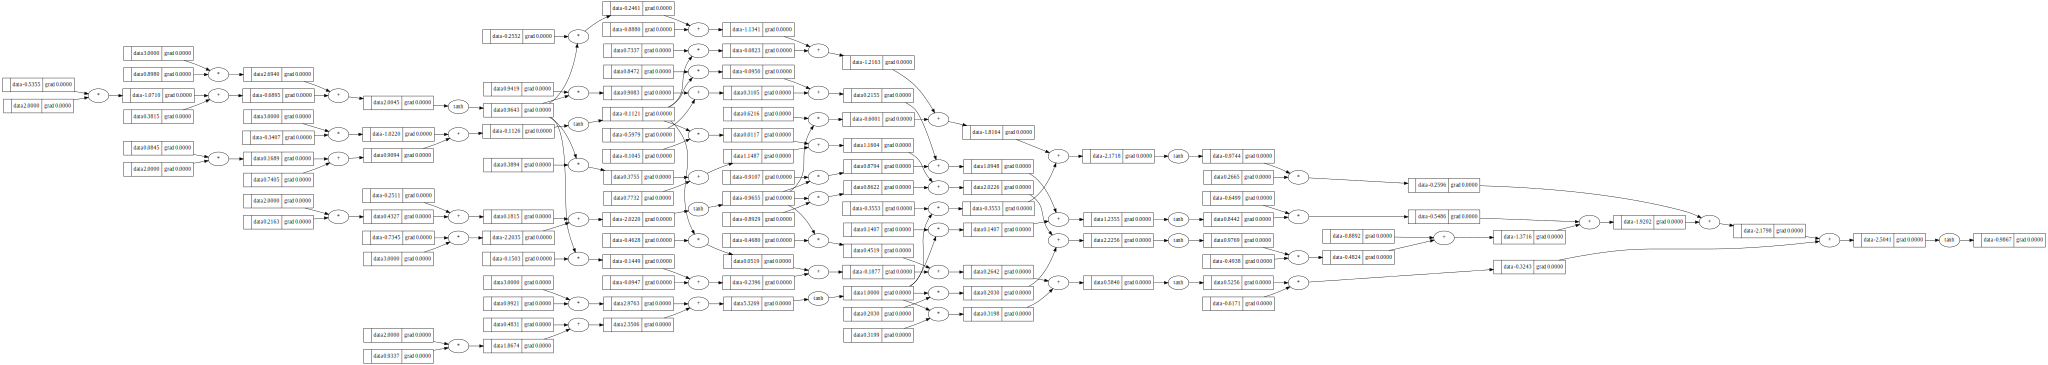

In [48]:
draw_dot(n(x))

In [70]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

ypred = [n(x) for x in xs]
ypred

[Value(data=0.006025121789395962),
 Value(data=0.09081516011829517),
 Value(data=-0.3579822416977641),
 Value(data=-0.1582402826936448)]

In [71]:
[(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]

[Value(data=0.9879860585137852),
 Value(data=1.1898777135439018),
 Value(data=0.4121868019754283),
 Value(data=1.3415205524542544)]

In [72]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=3.93157112648737)

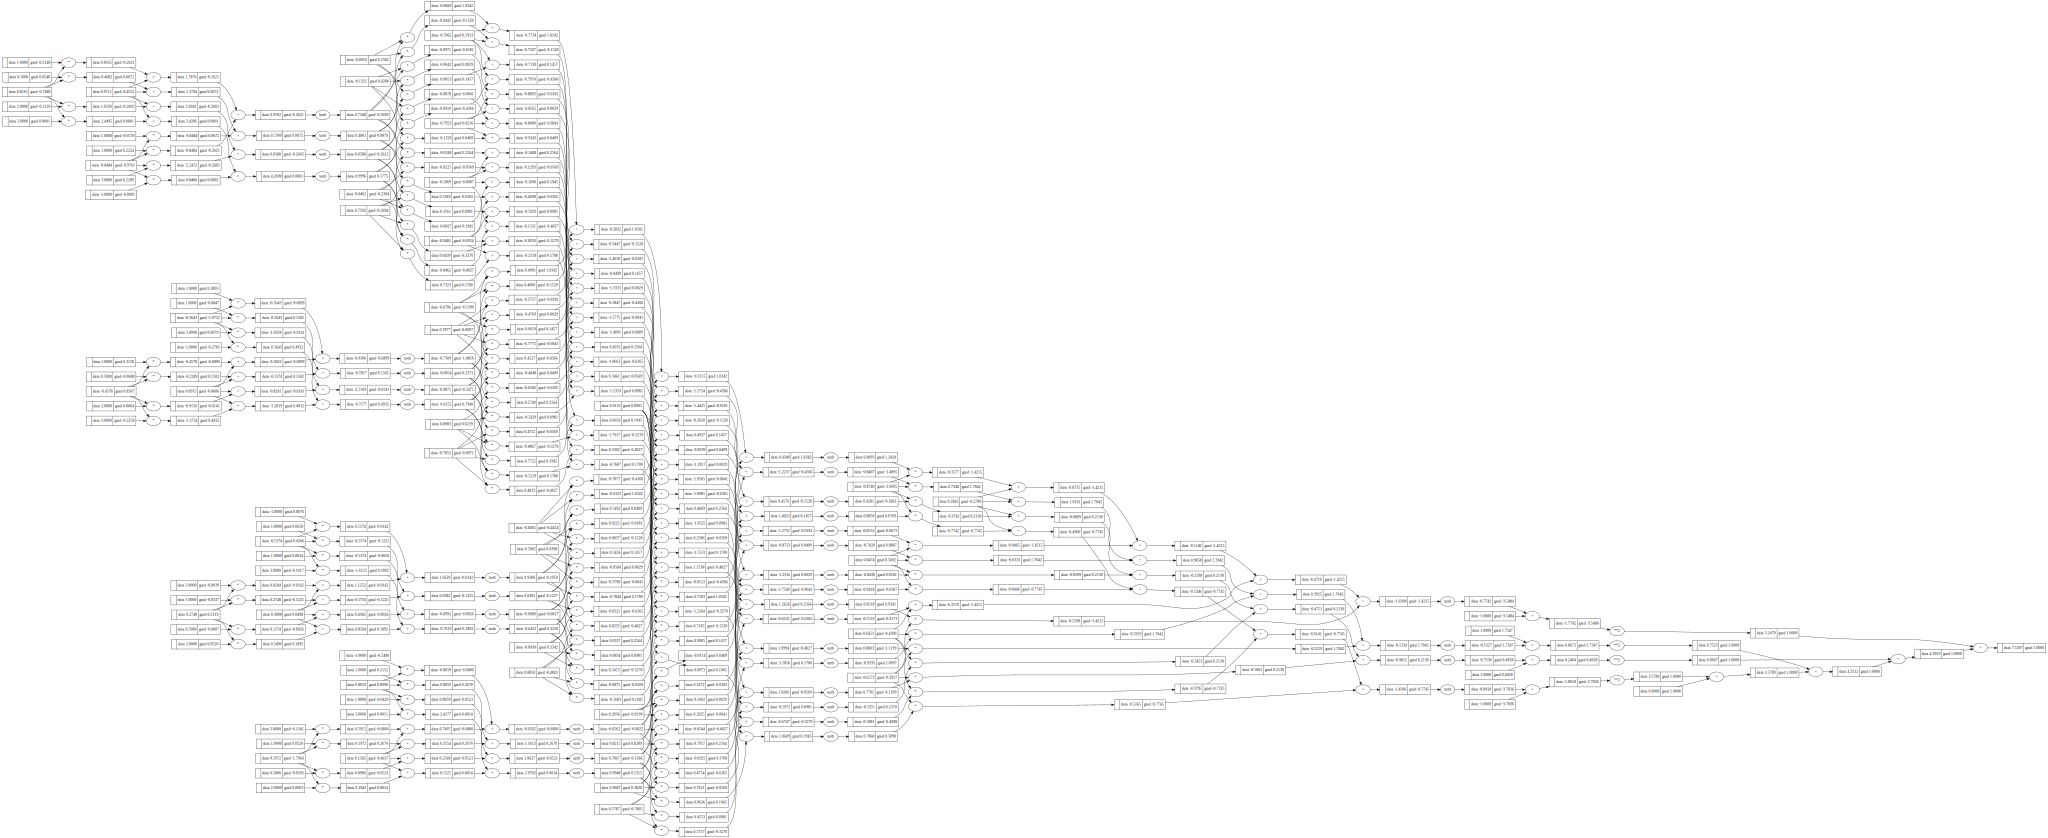

In [27]:
draw_dot(loss)

In [73]:
loss.backward()

In [74]:
n.layers[0].neurons[0].w[0].grad

0.3790660505244389

In [75]:
before_value = n.layers[0].neurons[0].w[0].data
before_value

0.6645803484013817

In [30]:
n.parameters()

[Value(data=0.8164941564063797),
 Value(data=-0.8484250062802015),
 Value(data=0.9711197598438928),
 Value(data=-0.4578126632159343),
 Value(data=-0.5642696349862497),
 Value(data=0.09150506988387219),
 Value(data=0.2748016283845771),
 Value(data=-0.5374267106039654),
 Value(data=0.3007764385890235),
 Value(data=0.1971669628952437),
 Value(data=0.8059152215410574),
 Value(data=0.1581985779640116),
 Value(data=-0.09101462804464333),
 Value(data=-0.6706251886524481),
 Value(data=-0.846487457992994),
 Value(data=0.913338010580719),
 Value(data=-0.7064703315199363),
 Value(data=-0.13209523884669228),
 Value(data=0.7876584387054826),
 Value(data=0.5901913820010454),
 Value(data=0.20359590372223968),
 Value(data=-0.7922558225313525),
 Value(data=0.7325663036192371),
 Value(data=0.8983385177667098),
 Value(data=-0.8429580799830434),
 Value(data=0.5787103816800352),
 Value(data=-0.9480855669054744),
 Value(data=-0.04624111638441386),
 Value(data=-0.7853182229476026),
 Value(data=0.884964933547

In [76]:
# gradient is a vector in the direction of increased loss. However, we aim
# to decrease the loss. So, we multiply the gradient by -(learning rate)
for p in n.parameters():
  p.data += -0.01 * p.grad

# This is called gradient descent. gradient descent means doing forward pass
# backward pass, and update in order to decrease the loss

In [77]:
after_value = n.layers[0].neurons[0].w[0].data
after_value

0.6607896878961373

In [78]:
before_value - after_value

0.0037906605052443476

In [79]:
ypred = [n(x) for x in xs]
# ypred
new_loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
print(f"the loss was {loss} and new loss is {new_loss}")

the loss was Value(data=3.93157112648737) and new loss is Value(data=3.691645226352933)


In [83]:
loss = new_loss
new_loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
new_loss.backward()
for p in n.parameters():
  p.data += -0.01 * p.grad

ypred = [n(x) for x in xs]
# ypred
new_loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
print(f"the loss was {loss} and new loss is {new_loss}")

the loss was Value(data=2.999634107101205) and new loss is Value(data=2.6523600189345427)


In [99]:

for k in range(20):

  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  # backward pass
  for p in n.parameters():
    # this is very important part of gradient descent
    p.grad = 0.0
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -0.07 * p.grad

  print(k, loss.data)


0 0.010785211037795981
1 0.010643574332312396
2 0.010505336361836775
3 0.010370380441126165
4 0.010238595053813512
5 0.010109873573510293
6 0.009984114002577257
7 0.009861218727280316
8 0.009741094288157504
9 0.009623651164513431
10 0.009508803572047819
11 0.009396469272700093
12 0.0092865693958666
13 0.009179028270211137
14 0.00907377326534961
15 0.008970734642744874
16 0.008869845415197884
17 0.008771041214367198
18 0.008674260165790785
19 0.008579442770923817


In [100]:
ypred

[Value(data=0.9984608161500095),
 Value(data=-0.956763787508545),
 Value(data=-0.9423238731242125),
 Value(data=0.9418521883300708)]

# Cross entropy loss
L(ŷ - y) = -(ylogŷ + (1-y)log(1 - ŷ))

